In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mbps.models.grass_sol import Grass
from mbps.models.water_sol import Water


In [14]:
import os
os.getcwd()
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
print(module_path)
sys.path.append(module_path[:-5])

C:\Users\Hao Xu\Desktop\WUR_MOBS\grass and water models\mbps


In [35]:
data_path = os.getcwd()[:-18]+'\\data\\uurgeg_260_2011-2020.csv.csv'

In [38]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in 'C:\\Users\\Hao Xu\\Desktop\\WUR_MOBS\\grass and water models\\mbps\\case3_files': ['.ipynb_checkpoints', 'grasswater_cal.py', 'grasswater_eval.py', 'grasswater_eval_2years.py', 'grasswater_sa.py', 'Untitled.ipynb']


In [297]:
plt.style.use('ggplot')

# Simulation time
tsim = np.linspace(0, 365 * 24, 24 * int(365) + 1)  # [d]

t_weather = np.linspace(0, 24 * 365, 24 * 365 + 1)

data_weather = pd.read_csv(
    '../../data/uurgeg_260_2011-2020.csv',  # .. to move up one directory from current directory
    skipinitialspace=True,  # ignore spaces after comma separator
    header=31 - 3,  # row with column names, 0-indexed, excluding spaces
    usecols=['YYYYMMDD', 'HH', 'T', 'Q', 'RH'],  # columns to use
)

In [299]:
data_weather

,YYYYMMDD,HH,T,Q,RH
0,20110101,1,36,0,-1
1,20110101,2,36,0,0
2,20110101,3,39,0,-1
3,20110101,4,42,0,-1
4,20110101,5,42,0,-1
...,...,...,...,...,...
87667,20201231,20,14,0,0
87668,20201231,21,6,0,0
87669,20201231,22,-10,0,0
87670,20201231,23,-17,0,0


In [300]:
data_weather['HH'] = pd.to_timedelta(data_weather['HH'],unit='h')
data_weather['HH'].iloc[0]
data_weather['HH'] = data_weather['HH'].astype(str).map(lambda x: x[7:])

In [301]:
# pd.to_datetime((data_weather.YYYYMMDD) + data_weather.HH.astype('timedelta64[h]'))
data_weather['date_time'] = pd.to_datetime(data_weather['YYYYMMDD'].astype(str)+ ' ' + data_weather['HH'])

In [308]:
data_weather

,YYYYMMDD,HH,T,Q,RH
date_time,,,,,
2011-01-01 01:00:00,20110101,01:00:00,36,0,-1
2011-01-01 02:00:00,20110101,02:00:00,36,0,0
2011-01-01 03:00:00,20110101,03:00:00,39,0,-1
2011-01-01 04:00:00,20110101,04:00:00,42,0,-1
2011-01-01 05:00:00,20110101,05:00:00,42,0,-1
...,...,...,...,...,...
2020-12-31 20:00:00,20201231,20:00:00,14,0,0
2020-12-31 21:00:00,20201231,21:00:00,6,0,0
2020-12-31 22:00:00,20201231,22:00:00,-10,0,0


In [307]:
data_weather = data_weather.set_index('date_time')
# data_weather

In [325]:
# Weather data (disturbances shared across models)
t_ini = '2011-01-01 01:00:00'
t_end = '2012-01-01 01:00:00'

# Grass data. (Organic matter assumed equal to DM) [gDM m-2]
# Groot and Lantinga (2004)
t_data = np.array([107, 114, 122, 129, 136, 142, 149, 156])
m_data = np.array([156., 198., 333., 414., 510., 640., 663., 774.])
m_data = m_data / 1E3

# ---- Grass sub-model
# Step size
dt_grs = 1/24  # [d]

# Initial conditions
# TODO: Specify suitable initial conditions for the grass sub-model
x0_grs = {'Ws': 1e-2, 'Wg': 3e-2}  # [kgC m-2]

# Model parameters (as provided by Mohtar et al. 1997 p.1492-1493)
p_grs = {'a': 40.0,  # [m2 kgC-1] structural specific leaf area
         'alpha': 2E-9,  # [kgCO2 J-1] leaf photosynthetic efficiency
         'beta': 0.05,  # [d-1] senescence rate
         'k': 0.5,  # [-] extinction coefficient of canopy
         'm': 0.1,  # [-] leaf transmission coefficient
         'M': 0.02,  # [d-1] maintenance respiration coefficient
         'mu_m': 0.5,  # [d-1] max. structural specific growth rate
         'P0': 0.432,  # [kgCO2 m-2 d-1] max photosynthesis parameter
         'phi': 0.9,  # [-] photoshynth. fraction for growth
         'Tmin': 0.0,  # [°C] maximum temperature for growth
         'Topt': 20.0,  # [°C] minimum temperature for growth
         'Tmax': 42.0,  # [°C] optimum temperature for growth
         'Y': 0.75,  # [-] structure fraction from storage
         'z': 1.33  # [-] bell function power
         }
# Model parameters adjusted manually to obtain growth
# TODO: Adjust a few parameters to obtain growth.
# Satrt by using the modifications from Case 1.
# If needed, adjust further those or additional parameters
p_grs['alpha'] = 4e-9
p_grs['beta'] = 0.025
# p_grs['gamma'] = 0.0

# Disturbances
# PAR [J m-2 d-1], environment temperature [°C], leaf area index [-]
T = data_weather.loc[t_ini:t_end, 'T'].values  # [0.1 °C] Env. temperature
I_gl = data_weather.loc[t_ini:t_end, 'Q'].values  # [J cm-2 d-1] Global irr.

In [326]:
I_gl.shape[0]/24

365.0416666666667

In [327]:
T = T / 10  # [0.1 °C] to [°C] Environment temperature
I0 = 0.45 * I_gl * 1E4 / 24  # [J cm-2 d-1] to [J m-2 d-1] Global irr. to PAR

d_grs = {'T': np.array([t_weather, T]).T,
         'I0': np.array([t_weather, I0]).T,
         }

# Initialize module
grass = Grass(tsim, dt_grs, x0_grs, p_grs)

# ---- Water sub-model
dt_wtr = 1/24  # [d]

# Initial conditions
# TODO: Specify suitable initial conditions for the soil water sub-model
x0_wtr = {'L1': 54, 'L2': 80, 'L3': 144, 'DSD': 1}  # 3*[mm], [d]

# Castellaro et al. 2009, and assumed values for soil types and layers
p_wtr = {'S': 10,  # [mm d-1] parameter of precipitation retention
         'alpha': 1.29E-6,  # [mm J-1] Priestley-Taylor parameter
         'gamma': 0.68,  # [mbar °C-1] Psychrometric constant
         'alb': 0.23,  # [-] Albedo (assumed constant crop & soil)
         'kcrop': 0.90,  # [mm d-1] Evapotransp coefficient, range (0.85-1.0)
         'WAIc': 0.75,  # [-] WDI critical, range (0.5-0.8)
         'theta_fc1': 0.36,  # [-] Field capacity of soil layer 1
         'theta_fc2': 0.32,  # [-] Field capacity of soil layer 2
         'theta_fc3': 0.24,  # [-] Field capacity of soil layer 3
         'theta_pwp1': 0.21,  # [-] Permanent wilting point of soil layer 1
         'theta_pwp2': 0.17,  # [-] Permanent wilting point of soil layer 2
         'theta_pwp3': 0.10,  # [-] Permanent wilting point of soil layer 3
         'D1': 150,  # [mm] Depth of Soil layer 1
         'D2': 250,  # [mm] Depth of soil layer 2
         'D3': 600,  # [mm] Depth of soil layer 3
         'krf1': 0.25,  # [-] Rootfraction layer 1 (guess)
         'krf2': 0.50,  # [-] Rootfraction layer 2 (guess)
         'krf3': 0.25,  # [-] Rootfraction layer 2 (guess)
         'mlc': 0.2,  # [-] Fraction of soil covered by mulching
         }

# Disturbances
# global irradiance [J m-2 d-1], environment temperature [°C], 
# precipitation [mm d-1], leaf area index [-].
T = data_weather.loc[t_ini:t_end, 'T'].values  # [0.1 °C] Env. temperature
I_glb = data_weather.loc[t_ini:t_end, 'Q'].values  # [J cm-2 d-1] Global irr.
f_prc = data_weather.loc[t_ini:t_end, 'RH'].values  # [0.1 mm d-1] Precipitation
f_prc[f_prc < 0.0] = 0  # correct data that contains -0.1 for very low values

T = T / 10  # [0.1 °C] to [°C] Environment temperature
I_glb = I_glb * 1E4 / dt_wtr  # [J cm-2 d-1] to [J m-2 d-1] Global irradiance
f_prc = f_prc / 10 / dt_wtr  # [0.1 mm d-1] to [mm d-1] Precipitation

d_wtr = {'I_glb': np.array([t_weather, I_glb]).T,
         'T': np.array([t_weather, T]).T,
         'f_prc': np.array([t_weather, f_prc]).T,
         }

In [328]:
# Initialize module
water = Water(tsim, dt_wtr, x0_wtr, p_wtr)

# ---- Run simulation
# Initial disturbance
d_grs['WAI'] = np.array([[0, 1, 2, 3, 4], [1., ] * 5]).T

In [329]:
# Iterator
# (stop at second-to-last element, and store index in Fortran order)
it = np.nditer(tsim[:-1], flags=['f_index'])
for ti in it:
    # Index for current time instant
    idx = it.index
    # Integration span
    tspan = (tsim[idx], tsim[idx + 1])
    print('Integrating', tspan)
    # Controlled inputs
    u_grs = {'f_Gr': 0, 'f_Hr': 0}  # [kgDM m-2 d-1]
    u_wtr = {'f_Irg': 0}  # [mm d-1]
    # Run grass model
    y_grs = grass.run(tspan, d_grs, u_grs)
    # Retrieve grass model outputs for water model
    d_wtr['LAI'] = np.array([y_grs['t'], y_grs['LAI']])
    # Run water model    
    y_wtr = water.run(tspan, d_wtr, u_wtr)
    # Retrieve water model outputs for grass model
    d_grs['WAI'] = np.array([y_wtr['t'], y_wtr['WAI']])

# Retrieve simulation results
t_grs, t_wtr = grass.t/24, water.t/24
WsDM, WgDM, LAI = grass.y['Ws'] / 0.4, grass.y['Wg'] / 0.4, grass.y['LAI']
L1, L2, L3 = water.y['L1'], water.y['L2'], water.y['L3'],
WAI = water.y['WAI']

Integrating (0.0, 1.0)
Integrating (1.0, 2.0)


ValueError: NumPy boolean array indexing assignment cannot assign 25 input values to the 23 output values where the mask is true

In [330]:
d_grs

{'T': array([[0.000e+00, 3.600e+00],
        [1.000e+00, 3.600e+00],
        [2.000e+00, 3.900e+00],
        ...,
        [8.758e+03, 1.050e+01],
        [8.759e+03, 1.040e+01],
        [8.760e+03, 1.020e+01]]),
 'I0': array([[0.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00],
        [2.000e+00, 0.000e+00],
        ...,
        [8.758e+03, 0.000e+00],
        [8.759e+03, 0.000e+00],
        [8.760e+03, 0.000e+00]]),
 'WAI': array([[0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
         0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
         0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
         0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
         0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.    

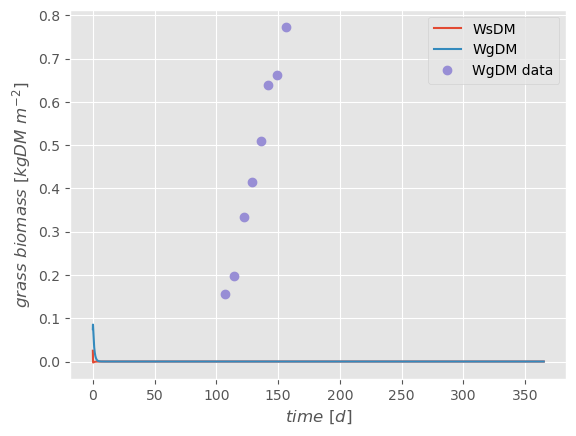

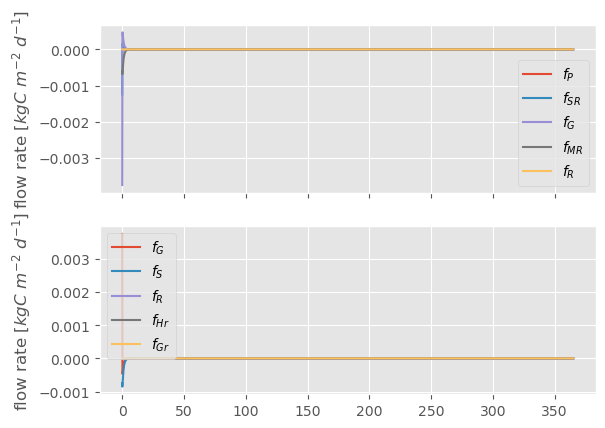

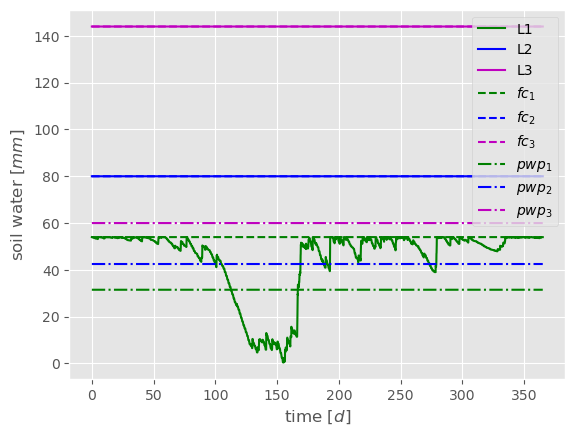

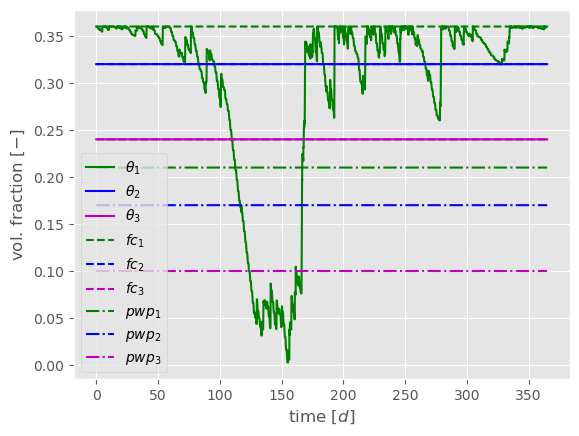

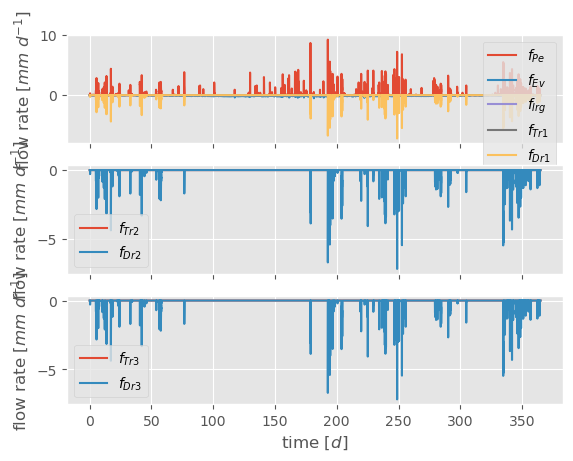

In [324]:
# ---- Plots
plt.figure(1)
plt.plot(t_grs, WsDM, label='WsDM')
plt.plot(t_grs, WgDM, label='WgDM')
plt.plot(t_data, m_data,
         linestyle='None', marker='o', label='WgDM data')
plt.legend()
plt.xlabel(r'$time\ [d]$')
plt.ylabel(r'$grass\ biomass\ [kgDM\ m^{-2}]$')

fig2, (ax2a, ax2b) = plt.subplots(2, 1, sharex=True)
ax2a.plot(t_grs, grass.f['f_P'], label=r'$f_{P}$')
ax2a.plot(t_grs, -grass.f['f_SR'], label=r'$f_{SR}$')
ax2a.plot(t_grs, -grass.f['f_G'], label=r'$f_{G}$')
ax2a.plot(t_grs, -grass.f['f_MR'], label=r'$f_{MR}$')
ax2a.plot(t_grs, grass.f['f_R'], label=r'$f_{R}$')
ax2a.legend()
ax2a.set_ylabel('flow rate ' + r'$[kgC\ m^{-2}\ d^{-1}]$')

ax2b.plot(t_grs, grass.f['f_G'], label=r'$f_{G}$')
ax2b.plot(t_grs, -grass.f['f_S'], label=r'$f_{S}$')
ax2b.plot(t_grs, -grass.f['f_R'], label=r'$f_{R}$')
ax2b.plot(t_grs, -grass.f['f_Hr'], label=r'$f_{Hr}$')
ax2b.plot(t_grs, -grass.f['f_Gr'], label=r'$f_{Gr}$')
ax2b.legend()
ax2b.set_ylabel('flow rate ' + r'$[kgC\ m^{-2}\ d^{-1}]$')

plt.figure(3)
plt.plot(t_wtr, L1, label='L1', color='g')
plt.plot(t_wtr, L2, label='L2', color='b')
plt.plot(t_wtr, L3, label='L3', color='m')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_fc1'] * p_wtr['D1']),
         linestyle='--', label=r'$fc_{1}$', color='g')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_fc2'] * p_wtr['D2']),
         linestyle='--', label=r'$fc_{2}$', color='b')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_fc3'] * p_wtr['D3']),
         linestyle='--', label=r'$fc_{3}$', color='m')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_pwp1'] * p_wtr['D1']),
         linestyle='-.', label=r'$pwp_{1}$', color='g')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_pwp2'] * p_wtr['D2']),
         linestyle='-.', label=r'$pwp_{2}$', color='b')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_pwp3'] * p_wtr['D3']),
         linestyle='-.', label=r'$pwp_{3}$', color='m')
plt.legend()
plt.xlabel('time ' + r'$[d]$')
plt.ylabel('soil water ' + r'$[mm]$')

plt.figure(4)
plt.plot(t_wtr, L1 / p_wtr['D1'], label=r'$\theta_{1}$', color='g')
plt.plot(t_wtr, L2 / p_wtr['D2'], label=r'$\theta_{2}$', color='b')
plt.plot(t_wtr, L3 / p_wtr['D3'], label=r'$\theta_{3}$', color='m')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_fc1']),
         linestyle='--', label=r'$fc_{1}$', color='g')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_fc2']),
         linestyle='--', label=r'$fc_{2}$', color='b')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_fc3']),
         linestyle='--', label=r'$fc_{3}$', color='m')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_pwp1']),
         linestyle='-.', label=r'$pwp_{1}$', color='g')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_pwp2']),
         linestyle='-.', label=r'$pwp_{2}$', color='b')
plt.plot(t_wtr, np.full((t_wtr.size,), p_wtr['theta_pwp3']),
         linestyle='-.', label=r'$pwp_{3}$', color='m')
plt.legend()
plt.xlabel('time ' + r'$[d]$')
plt.ylabel('vol. fraction ' + r'$[-]$')

fig5, (ax5a, ax5b, ax5c) = plt.subplots(3, 1, sharex=True)
ax5a.plot(t_wtr, water.f['f_Pe'], label=r'$f_{Pe}$')
ax5a.plot(t_wtr, -water.f['f_Ev'], label=r'$f_{Ev}$')
ax5a.plot(t_wtr, water.f['f_Irg'], label=r'$f_{Irg}$')
ax5a.plot(t_wtr, -water.f['f_Tr1'], label=r'$f_{Tr1}$')
ax5a.plot(t_wtr, -water.f['f_Dr1'], label=r'$f_{Dr1}$')
ax5a.legend()
ax5a.set_ylabel('flow rate ' + r'$[mm\ d^{-1}]$')

ax5b.plot(t_wtr, -water.f['f_Tr2'], label=r'$f_{Tr2}$')
ax5b.plot(t_wtr, -water.f['f_Dr2'], label=r'$f_{Dr2}$')
ax5b.legend()
ax5b.set_ylabel('flow rate ' + r'$[mm\ d^{-1}]$')

ax5c.plot(t_wtr, -water.f['f_Tr3'], label=r'$f_{Tr3}$')
ax5c.plot(t_wtr, -water.f['f_Dr3'], label=r'$f_{Dr3}$')
ax5c.legend()
ax5c.set_ylabel('flow rate ' + r'$[mm\ d^{-1}]$')
ax5c.set_xlabel('time ' + r'$[d]$')

plt.show()
# References
# Groot, J.C.J., and Lantinga, E.A., (2004). An object oriented model
#   of the morphological development and digestability of perennial
#   ryegrass. Ecological Modelling 177(3-4), 297-312.